In [1]:
import numpy as np
import magpylib as magpy
import pandas as pd
from magpylib.magnet import Cuboid, Cylinder, CylinderSegment
from maggeometry import n_rings, halbach_cylinder
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from maghelper import get_field_on_axes, get_nonuniformity, make_flux_stream, centered_sweep_range, get_grid_mag_and_nonuniformity, make_xy_grid

In [2]:
def calc_perf(file, startindex, endindex, numrings, savefile=False, isring=True):
    f = pd.read_csv(file)
    f = f.to_numpy()
    grid_res = 101
    grid = make_xy_grid([-10, 10], [-10, 10], grid_res)
    results_g_center = []
    results_nonun = []
    if isring:
        Br = 1.09e3
        mag_dir = (0,0,1)
        mirror_z = True
        ringset_config = [Br, mag_dir, mirror_z]
        ringset_config_nomirror = [Br, mag_dir, False]
        for x in f:
            obj_ring_config = []
            if numrings == 2:
                obj_ring_config=[[*ringset_config, *x[startindex:endindex+1]]]
            if numrings == 3:
                midindex = int((endindex+1 - startindex) / 2) + startindex
                obj_ring_config=[[*ringset_config_nomirror, *x[startindex:midindex]], [*ringset_config, *x[midindex:endindex+1]]]
            if numrings == 4:
                midindex = int((endindex+1 - startindex) / 2) + startindex
                obj_ring_config=[[*ringset_config, *x[startindex:midindex]], [*ringset_config, *x[midindex:endindex+1]]]
            magnets = n_rings(obj_ring_config)
            Gmag, Gnon, center_field, av_nonuniformity, max_abs_nonuniformity = get_grid_mag_and_nonuniformity(magnets, grid, grid_res, True)
            results_g_center.append(center_field)
            results_nonun.append(av_nonuniformity)
    else:
        Br = 1.09e3
        for x in f:
            magnets = halbach_cylinder(Br, x[startindex], c_h[0], x[endindex], n)
            Gmag, Gnon, center_field, av_nonuniformity, max_abs_nonuniformity = get_grid_mag_and_nonuniformity(magnets, grid, grid_res, True)
            results_g_center.append(center_field)
            results_nonun.append(av_nonuniformity)
    return results_g_center, results_nonun


In [3]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [25]:
def pp_make_start_finish_plots(figname, guess_nonun, guess_cf, comparison_results_file, headers, n_ringsets):

    cmp = pd.read_csv(comparison_results_file)
    cmp = cmp.to_numpy()
    cmp = np.delete(cmp, 0, 1)

    nplots = len(headers)
    fig_width = 20
    fig, axs = plt.subplots(1, nplots, figsize=(fig_width, 1/3*fig_width))
    # fig, axs = plt.subplots(1, 2)
    axs = axs.flat

    st2_width = cmp.shape[1]
    st2_nonun = cmp[:, 0]
    st2_field = cmp[:, 1]
    idx = 4 * n_ringsets + 2
    st1_nonun = cmp[:, idx]
    st1_field = cmp[:, idx+1]
    res = [[st1_nonun, st1_field], [st2_nonun, st2_field]]
    if (nplots == 3):
        res.insert(0, [guess_nonun, guess_cf])
    hfont = {'fontname':'Baskerville'}
    # fig.set_ylabel("Central field strength (Gauss)", **hfont)
    # fig.supxlabel("Nonuniformity", **hfont, fontsize=20)
    axs[0].set_ylabel("Central field strength (Gauss)", **hfont, fontsize=20)
    # fig.supylabel("Central field strength (Gauss)", **hfont)
    for i in range(nplots):
        axs[i].set_axisbelow(True)
        axs[i].axhline(10, color="green", linestyle="--", linewidth=0.5)
        axs[i].axhline(-10, color="green", linestyle="--", linewidth=0.5)
        axs[i].set_xlabel("Nonuniformity", **hfont, fontsize=20)
        axs[i].grid(color='.97', which='minor', axis='both', linestyle='-')
        axs[i].grid(color='.9', which='major', axis='both', linestyle='-')
        axs[i].set_title(headers[i], **hfont, fontsize=20)
        axs[i].set_xscale("log")
        axs[i].scatter(res[i][0], res[i][1], s=14, color='blue', zorder=1)
        axs[i].yaxis.set_minor_locator(MultipleLocator(100))
    axs[0].yaxis.set_major_locator(MultipleLocator(500))
    axs[2].set_ylim(-20, 20)
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14)
    plt.savefig(figname, dpi=1000)

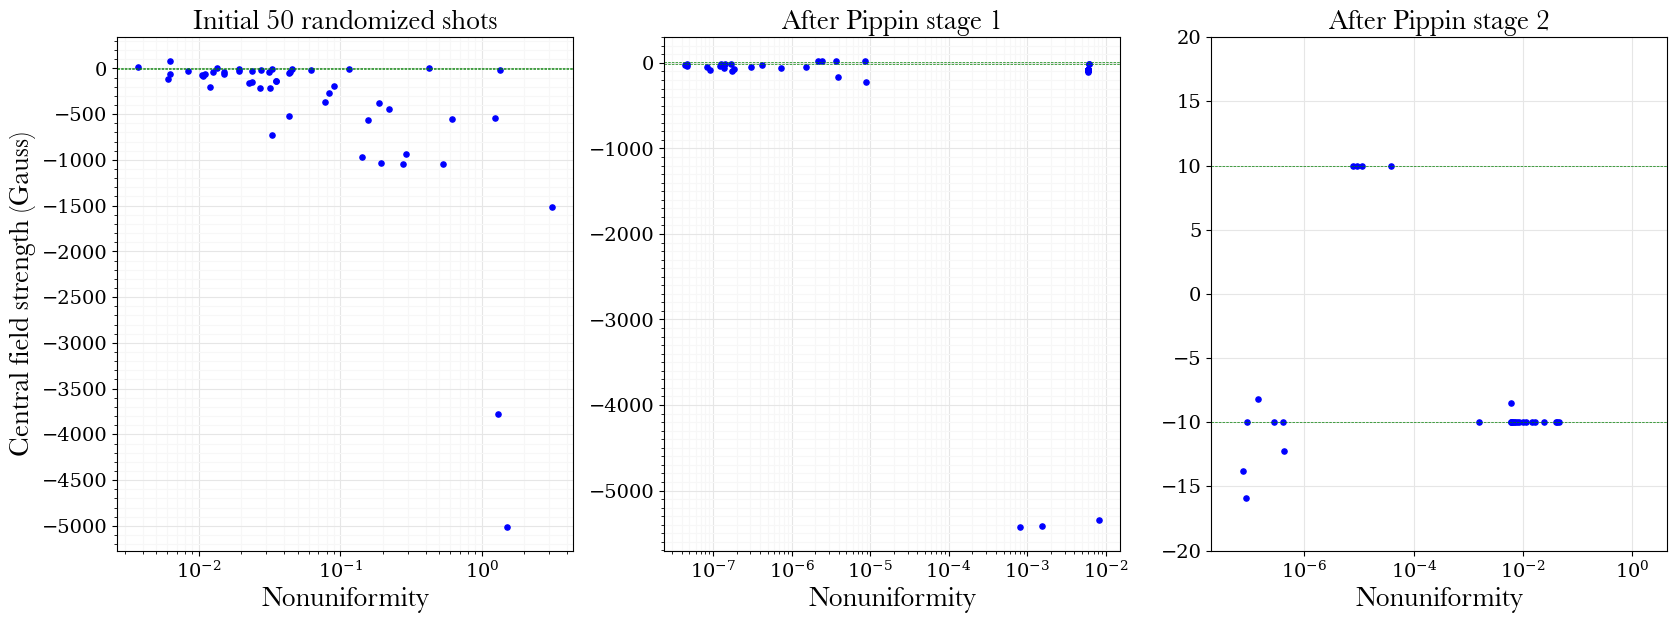

In [26]:
crf3r = 'results/3 rings/pippin/run1/2023_08_02_pippin2_3r_1090mT_part1_comparison_50_unsorted.csv'

headers =[
    "Initial 50 randomized shots",
    "After Pippin stage 1",
    "After Pippin stage 2",]
guess_cf3r, guess_nonun3r = calc_perf('results/3 rings/pippin/run1/2023_08_01_pippin1_3r_1090mT_49.csv', 11, 18, 3, True)
pp_make_start_finish_plots("figs/3rresults_pp.png", guess_nonun3r, guess_cf3r, crf3r, headers, 2)

Samwise plots

In [31]:
def sw_make_start_finish_plots(figname, guess_nonun, guess_cf, final_nonun, final_cf, headers):
    res = [[guess_nonun, guess_cf], [final_nonun, final_cf]]
    hfont = {'fontname':'Baskerville'}
    nplots = len(headers)
    fig_width = 20
    fig, axs = plt.subplots(1, nplots, figsize=(fig_width, 1/3*fig_width))
    axs = axs.flat
    axs[0].set_ylabel("Central field strength (Gauss)", **hfont, fontsize=20)
    for i in range(nplots):
        axs[i].set_axisbelow(True)
        axs[i].axhline(10, color="green", linestyle="--", linewidth=0.5)
        axs[i].axhline(-10, color="green", linestyle="--", linewidth=0.5)
        # axs[i].set_ylabel("Central field strength (Gauss)", **hfont)
        axs[i].set_xlabel("Nonuniformity", **hfont, fontsize=20)
        axs[i].grid(color='.97', which='minor', axis='both', linestyle='-')
        axs[i].grid(color='.9', which='major', axis='both', linestyle='-')
        axs[i].set_title(headers[i], **hfont)
        axs[i].set_xscale("log")
        axs[i].scatter(res[i][0], res[i][1], s=14, color='blue', zorder=1)
        axs[i].yaxis.set_minor_locator(MultipleLocator(100))
    axs[0].yaxis.set_major_locator(MultipleLocator(500))
    axs[1].set_ylim(-20, 20)
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14)
    plt.savefig(figname, dpi=1000)

[5.6944972140875905, -60.87546179869406, 1036.8858699025254, -55.152418680169895, 28.42213337966138, -9.968532775829825, -7.287597358839735, -33.645609524759834, -156.27881284668837, -2974.938394591082, -1133.1423120157037, -50.79346663243301, -6.711166687006869, -9.213918969720218, -654.0816527006331, -32.202741604231875, -109.48600143119722, -232.83517197407377, 3.6340480220930615, -2.683585174052738, -46.12962478841182, -25.484765329772063, -364.2908063224222, -0.010661298333962677, -79.309346255638, -526.0179533624432, -24.076327233122026, -64.72852769064454, 5.355630432640375, -676.8692558741675, -57.82926499246383, -20.895402919492092, -3319.0756218832685, 1.283884384139411, -941.6598370168324, -52.346607862712574, -1507.4119103555065, -48.30063158695077, -487.9639587397669, -3281.9784956008857, -228.80960044222212, -221.20027568071436, -687.518966739762, -18.557840884553265, -304.5451824305465, -3726.1288551617536, -133.5758277194188, -3211.1960695572143, -2213.3137727186668, -3

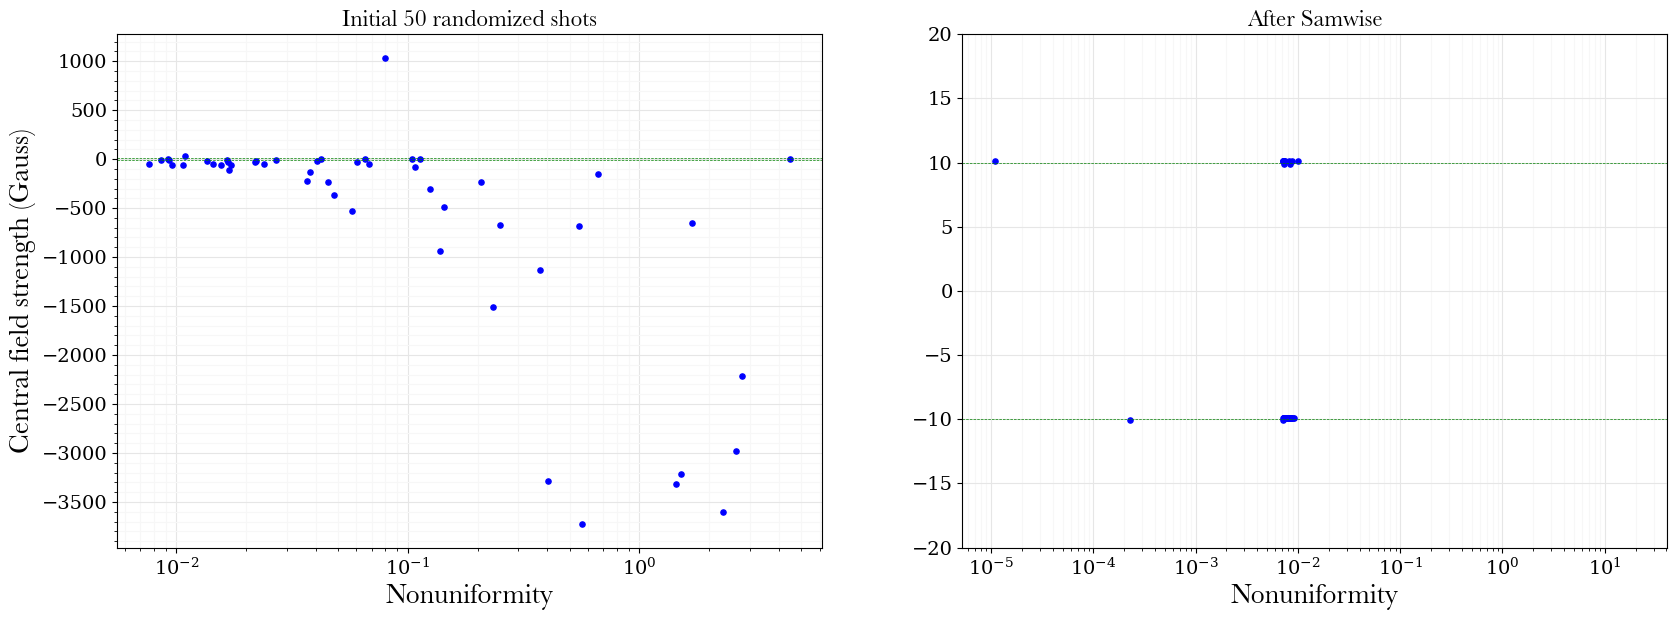

In [32]:
swheaders =[
    "Initial 50 randomized shots",
    "After Samwise",]
swres_cf3r, swres_nonun3r = calc_perf('results/3 rings/samwise/2023_07_30_samwise_sym_3r_1090mT_50.csv', 3, 10, 3, True)
swguess_cf3r, swguess_nonun3r = calc_perf('results/3 rings/samwise/2023_07_30_samwise_sym_3r_1090mT_50.csv', 11, 18, 3, True)
print (swguess_cf3r)
print(swres_nonun3r)
sw_make_start_finish_plots("figs/3rresults_sw.png", swguess_nonun3r, swguess_cf3r, swres_nonun3r, swres_cf3r, swheaders)